# Laboratorio 1

Bienvenidos al primer laboratorio de Deep Learning y Sistemas Inteligentes. 
Espero que este laboratorio les sirva para consolidar sus conocimientos de las primeras dos semanas. 

Este laboratorio consta de dos partes. En la primera trabajaremos una Regresión Logística con un acercamiento más a una Red Neuronal. En la segunda fase, usaremos PyTorch para crear un modelo similar pero ya usando las herramientas de Deep Learning aunque aún implementando algunos pasos "a mano".

Para este laboratorio estaremos usando una herramienta para Jupyter Notebooks que facilitará la calificación, no solo asegurándo que ustedes tengan una nota pronto sino también mostrandoles su nota final al terminar el laboratorio.

Por favor noten que es primera vez que uso este acercamiento para laboratorios por ende, pido su compresión y colaboración si algo no funciona como debería. Ayúdenme a mejorarlo para las proximas iteraciones.

## Antes de Empezar
Por favor actualicen o instalen la siguiente librería que sirve para visualizaciones de la calificacion, además de otras herramientas para calificar mejor las diferentes tareas.
Pueden correr el comando mostrado abajo (quitando el signo de comentario) y luego reiniciar el kernel (sin antes volver a comentar la linea), o bien, pueden hacerlo sdesde una cmd del ambiente de Anaconda

##### Creditos:
Esta herramienta pertence a sus autores, Dr John Williamson et al.

In [1]:
#!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master

La librería previamente instalada también tiene una dependencia, por lo que necesitarán instalarla.

In [2]:
#!pip install scikit-image

In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os

# Other imports
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string
import jhwutils.image_audio as ia
import jhwutils.tick as tick

###
tick.reset_marks()

%matplotlib inline

In [4]:
# Hidden cell for utils needed when grading (you can/should not edit this)
# Celda escondida para utlidades necesarias, por favor NO edite esta celda


###### Información del estudiante en dos variables

* carne : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)

In [5]:
carne = "22787+22129"
firma_mecanografiada = "Fabiola Contreras & María Villafuerte"

In [6]:
# Deberia poder ver dos checkmarks verdes [0 marks], que indican que su información básica está OK 

with tick.marks(0): 
    assert(len(carne)>=5)

with tick.marks(0):  
    assert(len(firma_mecanografiada)>0)

#### Dataset a Utilizar

Para este laboratorio estaremos usando el dataset de Kaggle llamado [Cats and Dogs image classification](https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification).
Por favor, descarguenlo y ponganlo en una carpeta/folder de su computadora local.

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samuelcortinhas/cats-and-dogs-image-classification")

print("Path to dataset files:", path)

c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Fabi\.cache\kagglehub\datasets\samuelcortinhas\cats-and-dogs-image-classification\versions\4


C:\Users\villa\.cache\kagglehub\datasets\samuelcortinhas\cats-and-dogs-image-classification\versions\4


## Parte 1 - Regresión Logística como Red Neuronal

**Créditos:** La primera parte de este laboratorio está tomado y basado en uno de los laboratorios dados dentro del curso de "Neural Networks and Deep Learning" de Andrew Ng

In [8]:
import kagglehub

# Download latest version of data
path = kagglehub.dataset_download("samuelcortinhas/cats-and-dogs-image-classification")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Fabi\.cache\kagglehub\datasets\samuelcortinhas\cats-and-dogs-image-classification\versions\4


In [9]:
data_dir = path

train_images = []
train_labels = []
test_images = []
test_labels = []

def read_images(folder_path, label, target_size, color_mode='RGB'):
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        # Use PIL to open the image
        image = Image.open(image_path)
        
        # Convert to a specific color mode (e.g., 'RGB' or 'L' for grayscale)
        image = image.convert(color_mode)
        
        # Resize the image to the target size
        image = image.resize(target_size)

        # Convert the image to a numpy array and add it to the appropriate list
        if label == "cats":
            if 'train' in folder_path:
                train_images.append(np.array(image))
                train_labels.append(0)  # Assuming 0 represents cats
            else:
                test_images.append(np.array(image))
                test_labels.append(0)  # Assuming 0 represents cats
        elif label == "dogs":
            if 'train' in folder_path:
                train_images.append(np.array(image))
                train_labels.append(1)  # Assuming 1 represents dogs
            else:
                test_images.append(np.array(image))
                test_labels.append(1)  # Assuming 1 represents dogs
# Call the function for both the 'train' and 'test' folders
train_cats_path = os.path.join(data_dir, 'train', 'cats')
train_dogs_path = os.path.join(data_dir, 'train', 'dogs')
test_cats_path = os.path.join(data_dir, 'test', 'cats')
test_dogs_path = os.path.join(data_dir, 'test', 'dogs')


# Read images
target_size = (64, 64)
read_images(train_cats_path, "cats", target_size)
read_images(train_dogs_path, "dogs", target_size)
read_images(test_cats_path, "cats", target_size)
read_images(test_dogs_path, "dogs", target_size)

In [10]:
# Convert the lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Reshape the labels
train_labels = train_labels.reshape((1, len(train_labels)))
test_labels = test_labels.reshape((1, len(test_labels)))

y = 0, es una imagen de un gato


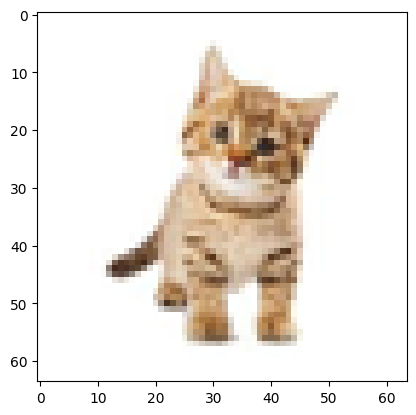

In [11]:
# Ejemplo de una imagen
index = 25
plt.imshow(train_images[index])
print ("y = " + str(train_labels[0][index]) + ", es una imagen de un " + 'gato' if train_labels[0][index]==0 else 'perro' +  "'.")

### Ejercicio 1
Para este primer ejercicio, empezaremos con algo súper sencillo, lo cual será soalmente encontrar los valores de las dimensiones de los vectores con los que estamos trabajando
 * m_train: número de ejemplos de entrenamiento
 * m_test: número de ejemplos de testing
 * num_px: Alto y ancho de las imagenes

In [12]:
m_train = len(train_images)
m_test = len(test_images)
num_px = train_images[0].shape[0]

print ("Número de datos en entrenamiento: m_train = " + str(m_train))
print ("Número de datos en testing: m_test = " + str(m_test))
print ("Alto y ancho de cada imagen: num_px = " + str(num_px))
print ("Cada imagen tiene un tamañado de: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Número de datos en entrenamiento: m_train = 557
Número de datos en testing: m_test = 140
Alto y ancho de cada imagen: num_px = 64
Cada imagen tiene un tamañado de: (64, 64, 3)
train_images shape: (557, 64, 64, 3)
train_labels shape: (1, 557)
test_images shape: (140, 64, 64, 3)
test_labels shape: (1, 140)


In [13]:
with tick.marks(2):
    assert m_train == 557
with tick.marks(2):
    assert m_test == 140
with tick.marks(1):
    assert num_px == 64

### Ejercicio 2
 
 Para conveniencia, deberán cambiar la forma (reshape) de las imagenes (num_px, num_px, 3) en cada numpy-array a una forma de (num_px $*$ num_px $*$ 3, 1). De esta manera, tanto el training como testing dataset sera un numpy-array donde cada columna representa una imagen "aplanada". Deberán haber m_train y m_test columnas
 

Entonces, para este ejercicio deben cambiar la forma (reshape) de tanto el dataset de entrenamiento como el de pruebas (training y testing) de esa forma, obtener un vector de la forma mencionada anteriormente (num\_px $*$ num\_px $*$ 3, 1)

Una forma de poder "aplanar" una matriz de forma (a,b,c,d) a una matriz de de forma (b$*$c$*$d, a), es usar el método "reshape" y luego obtener la transpuesta

```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T es la transpuesta de X
```

In [14]:
train_images_flatten = train_images.reshape(train_images.shape[0], -1).T
test_images_flatten = test_images.reshape(test_images.shape[0], -1).T

print ("train_images_flatten shape: " + str(train_images_flatten.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images_flatten shape: " + str(test_images_flatten.shape))
print ("test_labels shape: " + str(test_labels.shape))

train_images_flatten shape: (12288, 557)
train_labels shape: (1, 557)
test_images_flatten shape: (12288, 140)
test_labels shape: (1, 140)


In [15]:


# Test escondido para revisar algunos pixeles de las imagenes en el array aplanado 
# Tanto en training [3 marks]
# Como en test [2 marks]

Para representar el color de las imagenes (rojo, verde y azul - RGB) los canales deben ser específicados para cada pixel, y cada valor de pixel es de hecho un vector de tres números entre 0 y 255.

Una forma muy comun de preprocesar en ML es el centrar y estandarizar el dataset, es decir que se necesita restar la media de todo el array para cada ejemplo, y luego dividir cada observacion por la desviación estándar de todo el numpy array. Pero para dataset de imagenes, es más simple y más conveniente además que funciona tan bien, el solo dividir cada fila del dataset por 255 (el máximo del valor de pixeles posible.

Por ello, ahora estandarizaremos el dataset


In [16]:
train_set_x = train_images_flatten / 255.
test_set_x = test_images_flatten / 255.

### Arquitectura General
Ahora empezaremos a construir un algoritmo que nos permita diferenciar perros de gatos.

Para esto estaremos construyendo una Regresión Logística, usando un pensamiento de una Red Neuronal. Si se observa la siguiente imagen, se puede apreciar porque hemos dicho que la **Regresión Logística es de hecho una Red Neuronal bastante simple.** 

Recordemos la expresión matematica vista en clase.

Por ejemplo para una observación $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$



Recordemos que los pasos más importantes para construir una Red Neuronal son:
1. Definir la estructura del modelo (como el número de features de entrada)
2. Inicializar los parámetros del modelo
3. Iterar de la siguiente forma:
    a. Calcular la pérdida (forward)
    b. Calcular el gradiente actual (backward propagation)
    c. Actualizar los parámetros (gradiente descendiente)

Usualmente se crean estos pasos de forma separada para luego ser integrados en una función llamada "model()"

Antes de continuiar, necesitamos definir una función de soporte, conocida como sigmoide
Recuerden que para hacer predicciones, necesitamos calcular: 
$sigmoid(z) = \frac{1}{1 + e^{-z}}$ para $z = w^T x + b$


In [17]:
def sigmoid(z):
    """
    Computa el valor sigmoide de z

    Arguments:
    z: Un escalar o un numpy array 

    Return:
    s: sigmoide(z)
    """
    s = 1 / (1 + np.exp(-z))
        
    return s

### Ejercicio 3 - Inicializando parámetros con cero

Implemente la inicialización de parámetros. Tiene que inicializar w como un vector de zeros, considere usar np.zeros()

In [18]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    Crea un vector de zeros de dimensión (dim, 1) para w, inicia b como cero
    
    Argument:
    dim: Tamaño 
    
    Returns:
    w: Vector w (dim, 1)
    b: Escalar, debe ser flotante
    """

    w = np.zeros(dim)
    b = 0.0

    return w, b

In [19]:
dim = 3 # No cambiar esta dimensión por favor
w, b = initialize_with_zeros(dim)

print ("w = " + str(w))
print ("b = " + str(b))



w = [0. 0. 0.]
b = 0.0


### Ejercicio 4 - Forward and Backward propagation
Tras inicializar los parámetros, necesitamos hacer el paso de "forward" y "backward propagation" para optimizar los parámetros.

Para empezar, implemente la función "propagate()" que calcula la función de costo y su gradiente. 

**Recuerde**
* Si tiene X
* Se puede calcular $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
* Y luego se puede calcular la función de costo: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Por ende recuerd estas fórmulas (que probablemente estará usando):
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$


In [20]:

def propagate(w, b, X, Y):
    """
    Implementa la función de costo y su gradiente 

    Arguments:
    w: Pesos (num_px * num_px * 3, 1)
    b: bias, un escalar
    X: Data (num_px * num_px * 3, n ejemplos)
    Y: Etiquetas verdaderas (1, n ejemplos)

    Return:
    cost: Log-likelihood negativo 
    dw: Gradiente de la pérdida con respecto de w
    db: Gradiente de la pérdida con respecto de b
    
    Tips: Recuerde escribir su código paso por paso para la propagación, considere usar np.log y np.dot()
    """
    
    m = X.shape[1]
    Y = np.array(Y)
        
    # Forward propagation
    A = sigmoid(np.dot(w.T,X)+b)
    C = - (1/m)*np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    
    # Backward propagation 
    dw = (1/m)*np.dot(X, (A - Y).T)
    db = (1/m)*np.sum(A-Y)
    
    cost = np.squeeze(C)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [21]:
w =  np.array([[1.], [3]])
b = 4.5
X = np.array([[2., -2., -3.], [1., 1.5, -5.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))


with tick.marks(0): 
    assert type(grads["dw"]) == np.ndarray
with tick.marks(0): 
    assert grads["dw"].shape == (2, 1)
with tick.marks(0): 
    assert type(grads["db"]) == np.float64



dw = [[ 0.00055672]
 [-0.00048178]]
db = -0.0003283816747260056
cost = 0.000329022626806518


### Ejercicio 5 - Optimización

Escriba una función de optimización. El objetivo es aprender $w$ y $b$ al minimizar la función de costo $J$. Para un parametro $\theta$, la regla de actualización es $ \theta = \theta - \alpha \text{ } d\theta$, donde $\alpha$ es el learning rate.


In [22]:

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    Función que optmiza w y b al ejecutar el algoritmo de gradiente descendiente
    
    Arguments:
    w: Pesos (num_px * num_px * 3, 1)
    b: bias, un escalar
    X: Data (num_px * num_px * 3, n ejemplos)
    Y: Etiquetas verdaderas (1, n ejemplos)
    num_iterations: Número de iteraciones
    learning_rate: Learning rate
    print_cost: True para mostrar la pérdida cada 100 pasos
    
    Returns:
    params: Dictionario con w y b
    grads: Dictionario con las gradientes de los pesos y bias con respecto a J
    costs: Lista de todos los costos calculados
    
    Hints:
    Necesita escribir dos pasos de la iteracion:
        1. Calcular el costo y la gradiente de los parámetros actuales, Use propagate(), la funcion que definió antes
        2. Actualice los parametros usando la regla de gradiente descendiente para w y b
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Actualizar w y b
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [23]:
# Recuerde NO cambiar esto por favor
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))


w = [[0.99949949]
 [3.00043321]]
b = 4.50029528361711
dw = [[ 0.00055554]
 [-0.00048091]]
db = -0.0003278045123969942
Costs = [0.000329022626806518]


### Ejercicio 6 - Predicción

Con w y b calculados, ahora podemos hacer predicciones del dataset. Ahora implemente la función "predict()". 
Considere que hay dos pasos en la función de predicción:

1. Calcular  $\hat{Y} = A = \sigma(w^T X + b)$
2. Convertir la entrada a un 0 (si la activación es <= 0.5) o 1 (si la activación fue > 0.5), y guardar esta predicción en un vector "Y_prediction". 

In [24]:

def predict(w, b, X):
    '''
    Predice si la etiqueta es 0 o 1 usando lo aprendido
    
    Arguments:
    w: Pesos (num_px * num_px * 3, 1)
    b: bias, un escalar
    X: Data (num_px * num_px * 3, n ejemplos)
    
    Returns:
    Y_prediction: Numpy Array con las predicciones 
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Calcule el vector A para predicir probabilidades de que sea un gato o un perro
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        if A[0, i] > 0.5 :
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        
    
    return Y_prediction

In [25]:
w = np.array([[0.112368795], [0.48636775]])
b = -0.7
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
predictions_ = predict(w, b, X)
print ("predictions = " + str(predictions_))


predictions = [[0. 1. 0.]]


### Ejercicio 7 - Modelo

Implemente la función "model()", usando la siguiente notación:
* Y_prediction_test para las predicciones del test set
* Y_prediction_train para las predicciones del train set
* parameters, grads, costs para las salidas de "optimize()"

In [26]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Construye la regresión logística llamando las funciones hechas
    
    Arguments:
    X_train: Training set  (num_px * num_px * 3, m_train)
    Y_train: Training labels (1, m_train)
    X_test: Test set (num_px * num_px * 3, m_test)
    Y_test: Test labels (1, m_test)
    num_iterations: Número de iteraciones 
    learning_rate: Learning rate
    print_cost: True para mostrar la pérdida cada 100 pasos
    
    Returns:
    d: Dictionario conteniendo la info del modelo
    """

    # Inicializar los parametros con cero
    w = np.zeros((X_train.shape[0], 1))
    b = 0
    
    # gradient descent
    params, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    
    # Sacar los parametros del dictionary "params"
    w = params["w"]
    b = params["b"]
    
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)


    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [27]:
logistic_regression_model = model(train_set_x, train_labels, test_set_x, test_labels, num_iterations=2000, learning_rate=0.005, print_cost=True)



Cost after iteration 0: 0.693147
Cost after iteration 100: 2.052139
Cost after iteration 200: 1.878137
Cost after iteration 300: 1.758717
Cost after iteration 400: 1.663785
Cost after iteration 500: 1.582662
Cost after iteration 600: 1.510157
Cost after iteration 700: 1.443258
Cost after iteration 800: 1.380178
Cost after iteration 900: 1.319844
Cost after iteration 1000: 1.261642
Cost after iteration 1100: 1.205307
Cost after iteration 1200: 1.150853
Cost after iteration 1300: 1.098467
Cost after iteration 1400: 1.048387
Cost after iteration 1500: 1.000794
Cost after iteration 1600: 0.955770
Cost after iteration 1700: 0.913290
Cost after iteration 1800: 0.873235
Cost after iteration 1900: 0.835411
train accuracy: 67.14542190305207 %
test accuracy: 50.71428571428571 %


y = 0, predice que este es un "gato


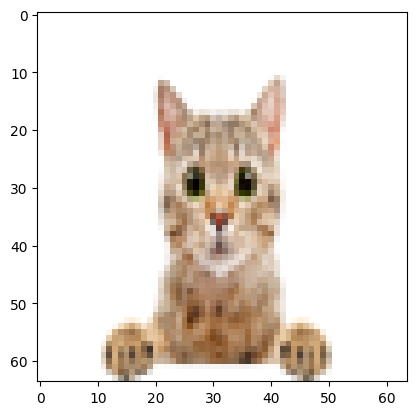

In [28]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3))) 
print ("y = " + str(test_labels[0,index]) + ", predice que este es un \"" + 'gato' if int(logistic_regression_model['Y_prediction_test'][0,index])==0 else 'perro' +  "\" picture.")

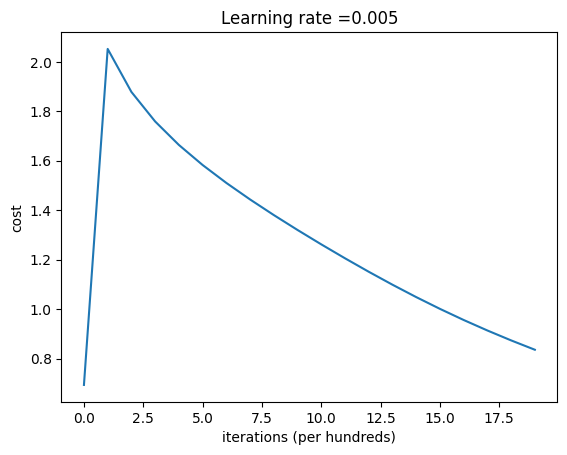

In [29]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

1. ¿Qué se podría hacer para mejorar el rendimiento de esta red?
- Para mejorar el rendimiento del modelo, lo más sencillo es asegurarse de que las imágenes estén bien normalizadas, por ejemplo, dividiendo los valores por 255 para que estén entre 0 y 1. También ayuda aumentar la cantidad de datos, ya sea consiguiendo más imágenes o aplicando técnicas de aumento como rotarlas o hacerles zoom, para que el modelo vea más variedad. Además, cambiar de la regresión logística a una red neuronal de múltiples capas o el uso de una red convolucional puede capturar con mayor precisión los detalles de las imágenes y optimizar significativamente los datos.

2. Interprete la gráfica de arriba
- Esta gráfica muestra el proceso de aprendizaje del modelo de regresión logística para clasificar gatos y perros. Los resultados son positivos, nos muestran que el costo empieza alto en alrededor de 2.1 y va bajando de manera constante hasta llegar a unos 0.83 después de 1800 iteraciones. Podemos observar que la curva es suave y no tiene saltos bruscos, lo que indica que el learning rate de 0.005 está bien calibrado - no es demasiado alto para causar oscilaciones, ni muy bajo para hacer del entrenamiento super lento. Al ir finalizando se ve que la curva se está aplanando, sugiriendo que el modelo está convergiendo y ya no mejora tanto con cada iteración, lo cual es normal y esperado en un entrenamiento exitoso.

## Parte 2 - Red Neuronal Simple con PyTorch

Para esta parte seguiremos usando el mismo dataset que anteriormente teníamos. 

Entonces volvamos a cargar las imagenes por paz mental :)

In [30]:
train_images = []
train_labels = []
test_images = []
test_labels = []

# Call the function for both the 'train' and 'test' folders
train_cats_path = os.path.join(data_dir, 'train', 'cats')
train_dogs_path = os.path.join(data_dir, 'train', 'dogs')
test_cats_path = os.path.join(data_dir, 'test', 'cats')
test_dogs_path = os.path.join(data_dir, 'test', 'dogs')


# Read images
target_size = (64, 64)
read_images(train_cats_path, "cats", target_size)
read_images(train_dogs_path, "dogs", target_size)
read_images(test_cats_path, "cats", target_size)
read_images(test_dogs_path, "dogs", target_size)


# Convert the lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#### Nuevas librerías a usar
Asegúrense de instalar las librerías que les hagan falta del siguiente grupo de import.

**Recuerden usar virtual envs!**

comando: pip install torch torchvision pillow

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.utils.data as data
import random


# Seed all possible
seed_ = 2023
random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)

# If using CUDA, you can set the seed for CUDA devices as well
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_)
    torch.cuda.manual_seed_all(seed_)
    
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = False

Para poder usar PyTorch de una mejor manera con nuestro dataset de imagenes, tendremos que "formalizar" la manera en que cargamos las imagenes. Para ello crearemos una clase que represente el Dataset con el que estaremos trabajando

In [32]:
class CatsAndDogsDataset(data.Dataset):
    def __init__(self, data_dir, target_size=(28, 28), color_mode='RGB', train=True):
        self.data_dir = data_dir
        self.target_size = target_size
        self.color_mode = color_mode
        self.classes = ['cats', 'dogs']
        self.train = train
        self.image_paths, self.labels = self.load_image_paths_and_labels()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = image.convert(self.color_mode)
        image = image.resize(self.target_size)
        image = np.array(image)
        image = (image / 255.0 - 0.5) / 0.5  # Normalize to range [-1, 1]
        image = torch.tensor(image, dtype=torch.float32)
        image = image.view(-1)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return image, label

    def load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_dir, 'train' if self.train else 'test', class_name)
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                image_paths.append(image_path)
                labels.append(class_idx)
        return image_paths, labels


### Definición de la red neuronal
Una de las formas de definir una red neuronal con PyTorch es através del uso de clases. En esta el constructor usualmente tiene las capas que se usaran, mientras que la función que se extiende "forward()" hace clara la relación entre las capas.

Para poder entenderlo, hay que leer desde la función más interna hacia afuera y de arriba hacia abajo. Por ejemplo, en la línea 8, la capa fc1 (que es una lineal), pasa luego a una función de activación ReLU, despues la información pasa a una segunda lineal (fc2), para finalmente pasar por una función de activación SoftMax

In [33]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # Feedforward step: Compute hidden layer activations
        x = self.fc2(x)              # Feedforward step: Compute output layer activations
        return F.log_softmax(x, dim=1)


### Definición de la función de entrenamiento

Una forma de entrenar una red neuronal con PyTorch es, tras haber definido el modelo, se pasa a definir una función que se encargará de realizar el entrenamiento. Esto incluye tanto el paso de feedforward como el de back propagation. 

Deberá terminar de implementar las funciones dadas según se solicita

En PyTorch, los pesos de una capa están en model.fc1.weight y model.fc1.bias.

torch.matmul es para sumatorias matmul(uno, dos)

Clase real Labels 
criterion = nn.NLLLoss()

In [26]:
loss_history = [] # DO NOT DELETE

def train_model(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.view(-1, input_size)

            # Feedforward step: Compute the predicted output
            
            # Aprox 1 a 3 líneas (depende del acercamiento), la salida debe ser:
            # outputs = 
            # Pueden usar un acercamiento step-by-step (puntos extra)
            #     En esta deberían usar primero 
            #     # hidden_layer_activations = # Usando torch.relu, torch.matmul
            #     # output_layer_activations = # Usando torch.matmul
            # O usar una forma más directa
                # YOUR CODE HERE
  
            hidden_layer_activations = torch.relu(torch.matmul(inputs, model.fc1.weight.T) + model.fc1.bias)
            output_layer_activations = torch.matmul(hidden_layer_activations, model.fc2.weight.T) + model.fc2.bias
            outputs = F.log_softmax(output_layer_activations, dim=1)

            # Compute the cost (loss)
            
            # Aprox 1 linea para calculo de la perdida
            # loss = 
            # YOUR CODE HERE
            loss = criterion(outputs, labels)

            
            # Backpropagation step: Compute gradients of the loss with respect to the model's parameters
            
            # Aprox 2 lineas para:
            # Limpiar gradientes previas usnado el optimizer
            # Computar las gradientes usando autograd
            # YOUR CODE HERE
            # Optimizer.zero_grad Reset the gradients of all optimized torch.Tensor s.
            optimizer.zero_grad()
            loss.backward()

            

            # Update the model's parameters using the computed gradients
            
            # Aprox 1 linea para:
            # Hacer un paso en la optimización, usar el optimizer
            # YOUR CODE HERE
            #optimizer’s update (calling optimizer.step()
            optimizer.step()


            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
        loss_history.append(running_loss/len(train_loader))

    print("Training complete!")

In [27]:
input_size = 64 * 64 * 3  
hidden_size = 125
output_size = 2  # 2 classes: cat and dog

model = SimpleClassifier(input_size, hidden_size, output_size)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Loading datasets
train_dataset = CatsAndDogsDataset(data_dir, target_size=(64, 64), color_mode='RGB', train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [28]:
train_model(model, train_loader, optimizer, criterion, epochs=5)

Epoch 1/5, Loss: 0.7020105752680037
Epoch 2/5, Loss: 0.6432293819056617
Epoch 3/5, Loss: 0.5961313843727112
Epoch 4/5, Loss: 0.5781968997584449
Epoch 5/5, Loss: 0.541928435365359
Training complete!


In [29]:
print("Loss:", loss_history)


Loss: [0.7020105752680037, 0.6432293819056617, 0.5961313843727112, 0.5781968997584449, 0.541928435365359]


También necesitamos una forma de probar nuestro modelo para ello usamos la siguiente

In [30]:
def test_model(model, test_loader):
    """
    Evaluate the performance of a trained neural network model on the test data.
    
    Arguments:
    model: The trained neural network model to be evaluated.
    test_loader: The DataLoader containing the test data and labels.
    """
    
    model.eval()  # Set the model in evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.view(-1, input_size)
            labels = labels.view(-1)  # Reshape the labels to be compatible with NLLLoss()

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [31]:
test_dataset = CatsAndDogsDataset(data_dir, target_size=(64, 64), color_mode='RGB', train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [32]:
# Evaluate the model on the test dataset
asset_accuracy = test_model(model, test_loader)

asset_accuracy


Test Accuracy: 57.14%


**NOTA:** Dentro de los comentarios de la entrega (en Canvas) asegurese de contestar
    
3. ¿En qué consiste ```optim.SGD```?

SGD es un algoritmo de optimización que actualiza los parámetros del modelo en la dirección opuesta al gradiente. "Estocástico" hace que tomemos muestras aleatorias (batches) en lugar del dataset completo. Actualiza los pesos usando la fórmula: peso_nuevo = peso_actual - learning_rate * gradiente.

4. ¿En qué consiste ```nn.NLLLoss```?

NLLLoss es una función de pérdida para clasificación multiclase. Nos ahorra el tener que hacer a mano la configuración de las fórmula para el cálculo de las pérdida. 

5. ¿Qué podría hacer para mejorar la red neuronal, y si no hay mejoras, por qué?
* Añadir más capas ocultas o más neuronas por capa
* Ajustar el learning rate (probar valores más pequeños como 0.001)
* Aumentar epochs de entrenamiento

Añadir más capas ocultas o neuronas permite al modelo aprender patrones más complejos y representaciones jerárquicas de las características de las imágenes, como bordes, texturas y formas específicas de gatos y perros. Ajustar el learning rate a valores más pequeños como 0.001 evita que el modelo "salte" sobre el mínimo óptimo durante el entrenamiento, permitiendo una convergencia más estable y precisa hacia mejores pesos. Aumentar los epochs de entrenamiento le da al modelo más oportunidades de ver los datos y ajustar gradualmente sus parámetros, especialmente importante en problemas de clasificación de imágenes donde se necesita tiempo para aprender las características distintivas entre las clases.


Al preguntarlse "en qué consiste...", se espera que las expliquelas en sus propias palabras

## Calificación

**Asegúrese de que su notebook corra sin errores (quite o resuelva los raise NotImplementedError()) y luego reinicie el kernel y vuelva a correr todas las celdas para obtener su calificación correcta**

In [33]:

print()
print("La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio")
tick.summarise_marks() # 



La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio
